In [33]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras import preprocessing
from google.colab import drive
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pathlib
import pandas as pd

In [34]:
drive.mount('/content/drive')

train_dir = pathlib.Path('/content/drive/MyDrive/ds/Food/Test')
test_dir = pathlib.Path('/content/drive/MyDrive/ds/Food/Train')

# turn images to dataset
train_data = tf.keras.utils.image_dataset_from_directory(train_dir)
train_classes = train_data.class_names

test_data = tf.keras.utils.image_dataset_from_directory(test_dir)
test_classes = test_data.class_names

train_classes, test_classes

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 600 files belonging to 3 classes.
Found 2400 files belonging to 3 classes.


(['apple_pie', 'hamburger', 'pizza'], ['apple_pie', 'hamburger', 'pizza'])

# **Visualize Data**

In [35]:
for img, label in train_data.take(1):
  print(img.shape)
  print(label.shape)

(32, 256, 256, 3)
(32,)


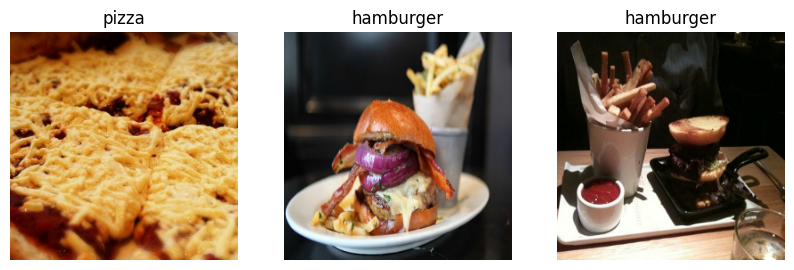

In [36]:
plt.figure(figsize=(10, 10))


for i in range(3):
  for img, lbl in train_data.take(1):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(img[i].numpy().astype("uint8"))
    plt.title(train_classes[lbl[i]])
    plt.axis("off")

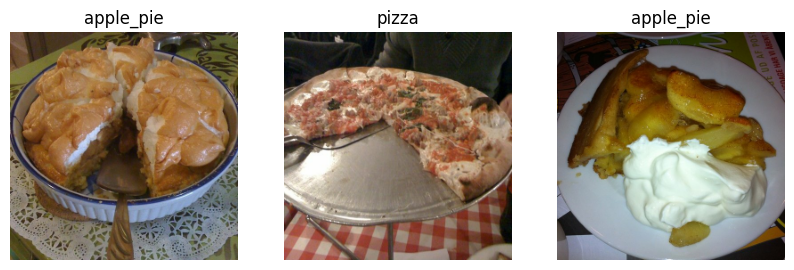

In [37]:
plt.figure(figsize=(10, 10))


for i in range(3):
  for img, lbl in test_data.take(1):
    ax = plt.subplot(2, 3, i + 1)
    plt.imshow(img[i].numpy().astype("uint8"))
    plt.title(test_classes[lbl[i]])
    plt.axis("off")

# **Data Preprocessing**

In [38]:
# encode classes
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
train_classes = le.fit_transform(train_classes)
test_classes = le.fit_transform(train_classes)

train_classes, test_classes

(array([0, 1, 2]), array([0, 1, 2]))

In [39]:
# convert labels to vectors
from tensorflow.keras.utils import to_categorical

train_classes = to_categorical(train_classes)
test_classes = to_categorical(test_classes)

train_classes, test_classes

(array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]),
 array([[1., 0., 0.],
        [0., 1., 0.],
        [0., 0., 1.]]))

In [40]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(180, 180),
  layers.Rescaling(1./255)
])

augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.3),
  layers.RandomZoom(0.3),
  layers.RandomContrast(0.3),
])


# **Model Building**

In [41]:
from tensorflow.keras.applications import EfficientNetV2L

eff = EfficientNetV2L(weights ='imagenet', include_top = False, input_shape = (256,256, 3))
eff.trainable = False # freeze learnt params

In [42]:
len(eff.layers)

1028

In [43]:
model = keras.Sequential([
    eff,
    augmentation,
    resize_and_rescale,
    Conv2D(32, (2,2), activation='relu'),
    MaxPooling2D(pool_size = 2),
    BatchNormalization(),
    Conv2D(64, (2,2), activation='relu'),
    MaxPooling2D(pool_size = 2),
    BatchNormalization(),
    Conv2D(128, (2,2), activation='relu'),
    MaxPooling2D(2,2),
    BatchNormalization(),
    Dense(64),
    Flatten(),
    Dense(3, activation='softmax')
  ])

In [44]:
model.compile(loss = 'sparse_categorical_crossentropy', optimizer = keras.optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In [45]:
history = model.fit(
    train_data,
    steps_per_epoch = len(train_data)//32,
    validation_data = test_data,
    validation_steps = len(test_data)//32,
    epochs = 35, batch_size = 32, verbose = 2)

Epoch 1/35
19/19 - 165s - 9s/step - accuracy: 0.8883 - loss: 0.8004 - val_accuracy: 0.3281 - val_loss: 1.0903
Epoch 2/35
19/19 - 23s - 1s/step - accuracy: 0.9467 - loss: 0.5857 - val_accuracy: 0.2656 - val_loss: 1.3614
Epoch 3/35
19/19 - 41s - 2s/step - accuracy: 0.9567 - loss: 0.5058 - val_accuracy: 0.6406 - val_loss: 1.1486
Epoch 4/35
19/19 - 41s - 2s/step - accuracy: 0.9567 - loss: 0.5238 - val_accuracy: 0.2500 - val_loss: 1.8337
Epoch 5/35
19/19 - 23s - 1s/step - accuracy: 0.9483 - loss: 0.6658 - val_accuracy: 0.3594 - val_loss: 1.2252
Epoch 6/35
19/19 - 23s - 1s/step - accuracy: 0.9583 - loss: 0.5669 - val_accuracy: 0.2500 - val_loss: 2.7082
Epoch 7/35
19/19 - 41s - 2s/step - accuracy: 0.9783 - loss: 0.1514 - val_accuracy: 0.5156 - val_loss: 1.0245
Epoch 8/35
19/19 - 41s - 2s/step - accuracy: 0.9867 - loss: 0.1657 - val_accuracy: 0.6875 - val_loss: 1.2833
Epoch 9/35
19/19 - 23s - 1s/step - accuracy: 0.9850 - loss: 0.2140 - val_accuracy: 0.3438 - val_loss: 3.1730
Epoch 10/35
19/19 

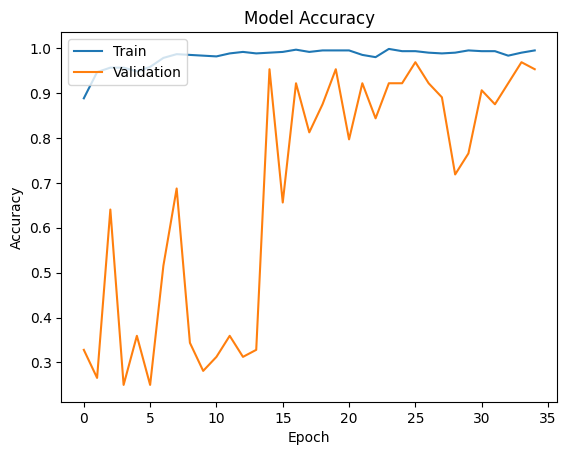

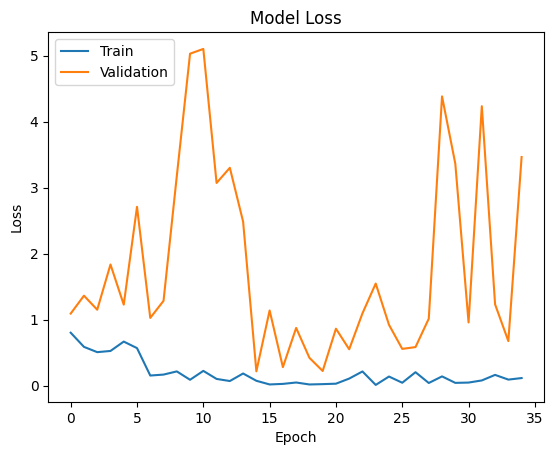

In [46]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#**Saving and Loading Model**

In [47]:
import pickle

with open('model.pkl', 'wb') as file:
  pickle.dump(model, file)

In [48]:
with open('model.pkl', 'rb') as file:
  test_model = pickle.load(file)

#**Testing Model**

In [49]:
test_model

<Sequential name=sequential_10, built=True>

In [51]:
evaluate = model.evaluate(test_data)

75/75 ━━━━━━━━━━━━━━━━━━━━ 61s 808ms/step - accuracy: 0.9630 - loss: 1.0990
